In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model

# reflect the tables
# Create an instance of automap_base
Base = automap_base()

# Reflect the tables from the database
Base.prepare(engine, reflect=True)



In [21]:
# View all of the classes that automap found
# Print the names of the reflected tables
print("Reflected Tables:")
print(Base.classes.keys())

Reflected Tables:
['measurement', 'station']


In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station




In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set.
# Query to retrieve the most recent date from the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the dataset:", most_recent_date)

The most recent date in the dataset: 2017-08-23


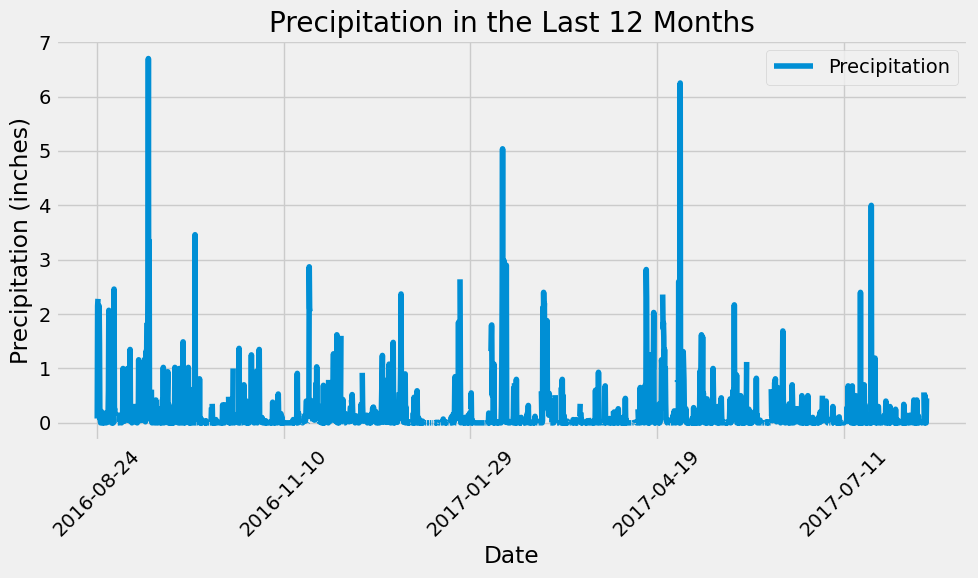

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Calculate the date one year from the last date in the data set
from datetime import datetime, timedelta

# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert the most recent date to a datetime object
most_recent_datetime = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_datetime - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])


# Sort the DataFrame by date
df = df.sort_values('Date')


# Use Pandas Plotting with Matplotlib to plot the data

df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Design a query to retrieve the last 12 months of precipitation data and plot the results













In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

print("Summary Statistics for Precipitation Data:")
print(summary_statistics)


Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset

# Query to count the distinct number of stations in the Station table
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)


Total number of stations: 9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


# Design a query to find the most active stations and their row counts in descending order

# Query to group the Measurement table by station and calculate the row count for each station
# Then order the result in descending order based on row count
active_stations_query = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
print("Most Active Stations (Station, Row Count):")
for station, row_count in active_stations_query:
    print(f"{station}: {row_count}")


Most Active Stations (Station, Row Count):
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station id from the previous query (first entry in the result list)
most_active_station = active_stations_query[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0][0]} °F")
print(f"Highest Temperature: {temperature_stats[0][1]} °F")
print(f"Average Temperature: {temperature_stats[0][2]} °F")


Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


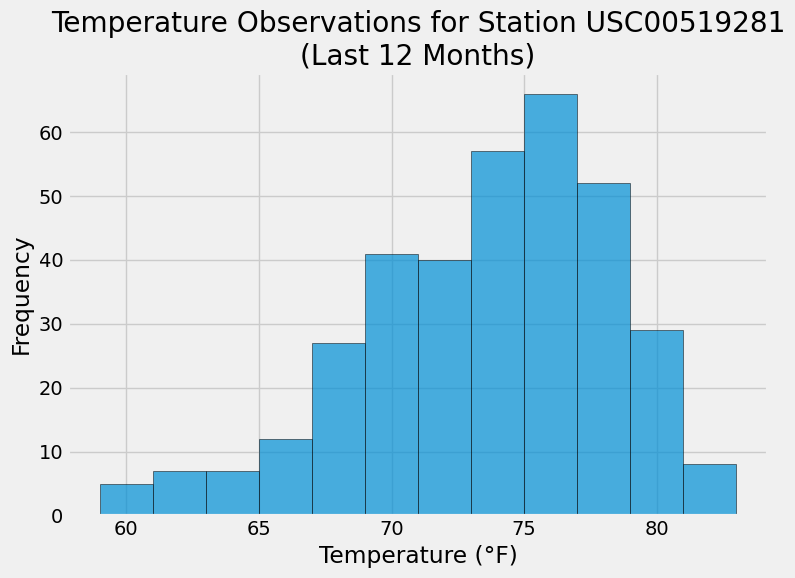

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query result to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Create a histogram using Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}\n(Last 12 Months)")
plt.tight_layout()
plt.show()


# Close Session

In [32]:
# Close Session
session.close()